# Edge Detection

## Pendahuluan

### Import Library yang Dibutuhkan

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

### Fungsi Penting

In [2]:
def show_image(title, img) : 
    plt.imshow(img, cmap = 'gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


### Baca dan Tampilkan Gambar

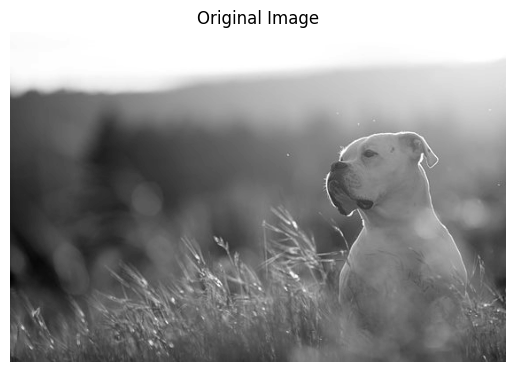

In [3]:
img = cv2.imread('img.jpg', 0) # Buka gambar dan conver gambar ke abu abu
show_image('Original Image', img)

## Steps of Edge Detection

1. Filtering : Melakukan smoothing pada image untuk menghindari spurious edge.
2. Enchancement : Menerapkan turunan numerik untuk mendeteksi boundary
3. Detection : Melakukan thresholding pada image untuk mencari strong rges.
4. Localization : Membuang spurious edge dan memperkuat edge yang lemah.

## Canny Edge Detection
Pada pendeteksian metode canny, metode yang digunakan juga berasak dari 4 tahap pendeteksian di atas yaitu :
1. Noice Reduction
2. Gradient Calculation
3. Non Maximum Supression
4. Double Thresholding
5. Edge Tracking by Hysterisis

### Step 1 - Noice Reduction 

Melakukan smoothing pada gambar menggunakan LPF Gaussian Blur.

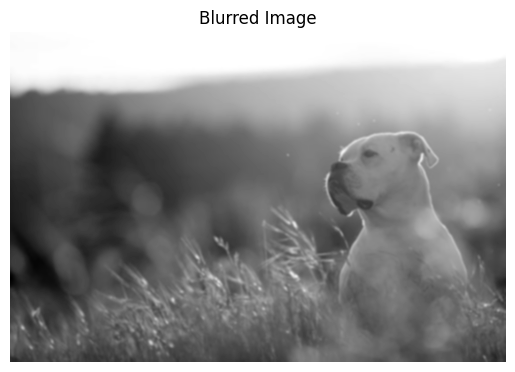

In [4]:
# Melakukan typecast tipe data dari int ke float agar bisa dimasukkan ke fungsi gaussianBlur dari cv2 yang hanya bisa menerima float
img = img.astype(np.float64) 

'''
Melakukan noice reduction dengan Gaussian Blur. 

cv2.GaussianBlur() menerima 3 parameter yaitu 
src : img => Gambar dalam satuan Float
kernel size : (5, 5) => Ukuran kernel. Dipilih ukuran (5, 5)
sigmaX : 0 => Standar Deviasi sepanjang sumbu X
'''
img_blur = cv2.GaussianBlur(img, (5, 5), 0)
show_image('Blurred Image', img_blur)

### Step 2 - Gradient Calculation

Tahap ini merupakan tahap untuk mendeteksi boundary dengan menerapkan turunan numerik. 

Beberapa tahap yang akan dilakukan adalah
1. Melakukan smoothing pada gambar (sudah dilakukan di atas)
2. Menghitung turunan numerik $\hat{f_x}$ dan $\hat{f_y}$ di mana

$$
\hat{f_x} = \hat{f(x,y)} * M_x(x,y) \\
\hat{f_y} = \hat{f(x,y)} * M_y(x,y)
$$

Dengan $M_x$ dan $M_y$ merupakan sebuah mask. Mask yang digunakan pada kasus adalah Sobel Operator di mana 

$$ M_x = 
\begin{pmatrix} 
    -1 & 0 & 1 \\
    -2 & 0 & 2 \\
    -1 & 0 & 1 
\end{pmatrix}
$$

$$ M_y = 
\begin{pmatrix} 
    -1 & -2 & -1 \\
    0 & 0 & 0 \\
    -1 & 2 & 1 
\end{pmatrix}
$$

3. Hitung $magn(x,y) = \sqrt{\hat{f_x}^2 +\hat{f_y}^2 }$
4. Hitung $dir(x,y) = \arctan{(\frac{\hat{f_y}}{\hat{f_x}})}$
5. Jika $magn(x,y) = > T$ di mana $T$ merupakan threshold point, maka titik tersebut memiliki kemungkinan sebagai edge


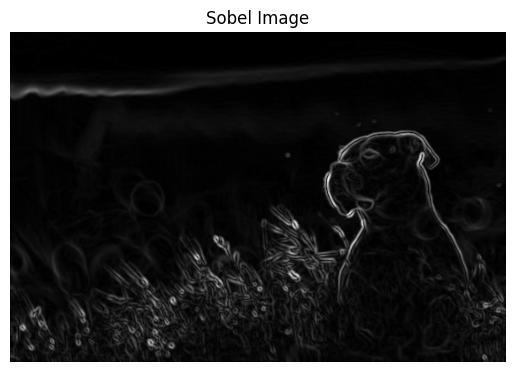

In [5]:
from scipy import ndimage as nd

def sobel(img) :
    '''
    Fungsi untuk mendeteksi edge dengan operator Sobel sesuai dengan 5 tahap di markdown step 2.
    '''

    # Membuat array untuk mask sobel operator untuk M_x dan M_y    
    M_x = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ], dtype = np.float32)
    
    M_y = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ], dtype = np.float32)
    
    
    # Melakukan convolution pada gambar dengan f_x = f * M_x dan f_y = f * M_y
    f_x = nd.filters.convolve(img, M_x)
    f_y = nd.filters.convolve(img, M_y)
    
    # Menghitung magnitue dari f_x dan f_y
    magnitude = np.sqrt(f_x ** 2 + f_y ** 2) 
    magnitude = magnitude / magnitude.max() * 255 # Melakukan pengskalaan agar terbatas sampai 255
    direction = np.arctan2(f_y, f_x)
    
    return (magnitude, direction)

img_sobel, direction = sobel(img_blur)

show_image('Sobel Image', img_sobel)

### Step 3 - Menerapkan Non Max Suppression

Pada hasil sobel, kita dapat perhatikan bahwa hasil edgenya lebih dari satu pixel. Sementara, untuk mendeteksi edge haruslah pixel yang diperoleh hanya 1. Maka dari itu perlu diterapkan Non Max Supression.

Non Max Supression mencari edge mana yang cukup strong. 
Non Max supression menggunaakan nilai dan arah dari gradient calculation di mana nilai dan arah dari gradien calculation yang bukan merupakan maksimum lokal akan dibuang atau dinolkan. Sehingga yang tersisa adalah nilai dari maksimum lokal yang menandakan edge yang cukup kuat.

Algoritma dari Non Max Supression adalah 
1. Telusuri semua intensitas pada gradient calculation.
2. Cari pixel dengan nilai maksimum pada arah yang sama.

```
for each pixel (x,y) do 
    if magn(i, j) < magn(i_1, j_1) or magn(i, j) < magn(i_2, j_2) then
        i_N(i, j) = 0
    else i_N(i,j) = magn(i, j)
```

### Ilustrasi
![alt](NMS.jpg)

### 3.1 - Method Find Neighbour 

Ketika melakukan Non-Max Supression, kita perlu terlebih dahulu mengetahui mana tetangga (neighbour) yang dimaksud berdasarkan angle. Maka, perlu dibuat method untuk mencari neighbour berdasarkan angle dengan ketentuan seperti di gambar berikut

![Find Neighbour](Find%20Neighbour.jpg)

Dengan $j$ menandakan pixel horizontal dan $i$ menyatakan pixel vertikal dan $(i, j)$ adalah pixel yang sedang ditelusuri

In [6]:
def find_neighbour(img, angle, i, j) :
    ''' 
    Fungsi untuk mencari neighbour dari pixel yang dicari yaitu angle[i,j]
    '''
    
    n_prev, n_next = 255, 255

    # Lakukan pencarian neighbour berdasarkan ilustrasi di atas
    
    # 0 Derajat
    if (angle[i,j] <= 22.5) or (157.5 <= angle[i, j] <= 180) :
        n_prev = img[i, j + 1]
        n_next = img[i, j - 1]
        
    # 45 Derajat 
    if(22.5 <= angle[i, j] <= 67.5) :
        n_prev = img[i + 1, j - 1]
        n_next = img[i - 1, j + 1]
    
    # 90 Derajat
    if (67.5 <= angle[i, j] <= 112.5) :
        n_prev = img[i + 1, j]
        n_next = img[i - 1, j]
        
    # 135 Derajat
    if (112.5 <= angle[i, j] <= 157.5) :
        n_prev = img[i - 1, j - 1]
        n_next = img[i + 1, j + 1]
        
    return n_prev, n_next

### Step 3.2 - Terapkan NMS

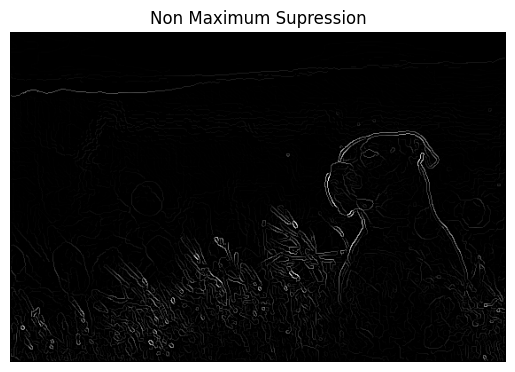

'\nOutput gambar : \nPixel Edge yang memiliki nilai local maxima saja yang tersisa.\n'

In [7]:
def non_max_supression(img, direction) :
    '''
    Fungsi untuk melakukan non-max supression. 
    Parameter 1 : image
    Parameter 2 : Arah (sudut)
    '''

    # Menentukan height dan width gambar menggunakan img.shape
    height, width = img.shape
    
    # Menyiapkan array untuk menyimpan Intensitas image
    I = np.zeros((height, width), dtype = np.int32)
    
    # Konversi angle ke degree
    angle = direction * 180.0 / np.pi
    angle[angle < 0] += 180
    
    for i in range(1, height - 1) :
        for j in range(1, width - 1) :
            
            # Mengidentifikasi setiap neighbour 
            n_prev, n_next = find_neighbour(img, angle, i, j)
            
            # Menerapkan algoritma NMS, buang pixel yang bukan local maxima dan pertahankan pixel yang merupakan local maxima
            if(img[i, j] >= n_prev) and (img[i, j] >= n_next) :
                I[i, j] = img[i, j]
            else : 
                I[i, j] = 0
                
    return I

nms_img = non_max_supression(img_sobel, direction)
show_image('Non Maximum Supression', nms_img)

'''
Output gambar : 
Pixel Edge yang memiliki nilai local maxima saja yang tersisa.
'''

### Step 3 - Double Thresholding

Thresholding dimaksudkan untuk mendidentifikasi mana edge yang kuat, lemah, dan bukan edge.

Pada Thresholding, terdapat beberapa kriteria yang harus diperhatikan yaitu :
Jika $t_H$ menyatakan high threshold dan $t_L$ menyatakan low threshold maka
1. Strong Edge $\rightarrow$ Edge yang kuat, dengan kriteria $I > t_H$
2. Weak Edge $\rightarrow$ Edge yang lemah, dengan kriuteria $t_L \leq I \leq t_H $ 
3. Not an edge $\rightarrow$ Bukan edge, dengan kriteria $I < t_L$

Biasanya, nilai threshold yang dipilih memiliki perbandingan $t_H = 2t_L$

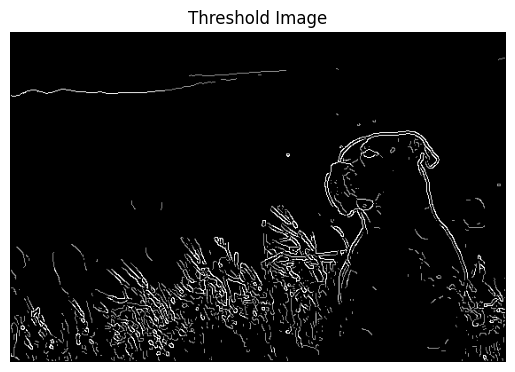

'\nOutput Gambar :\nGambar yang sudah terklasifikasi untuk bagian edge strong dan edge weak dan yang bukan edge.\n'

In [8]:
def threshold(img, tL, tH) :
    '''
    Fungsi untuk melakukan identifikasi pixel dan melakukan klasifikasi edge.
    '''
    # Menentukan height dan width gambar menggunakan img.shape
    height, width = img.shape
    
    # Menyiapkan array untuk menyimpan Intensitas Threshold image
    t = np.zeros((height, width), dtype = np.int32)
    
    # Define intensitas yang lemah dan yang kuat. Lemah = 150 dan Kuat = 255
    weak = np.int32(150)
    strong = np.int32(255)
    
    # Melakukan klasifikasi terhadap edge yang kuat, lemah dan bukan edge berdasarkan kriteria pada markdown Step 3
    strong_i, strong_j = np.where(img >= tH)
    not_an_edge_i, not_an_edge_j = np.where(img < tL)
    weak_i, weak_j = np.where((img <= tH) & (img >= tL)) 
    
    # Semua edge strong diberikan intensitas strong, weak edge diberikan intensitas weak
    t[strong_i, strong_j] = strong
    t[weak_i, weak_j] = weak
    
    return t

thresh_img = threshold(nms_img, 25, 50)   
show_image('Threshold Image', thresh_img)

'''
Output Gambar :
Gambar yang sudah terklasifikasi untuk bagian edge strong dan edge weak dan yang bukan edge.
'''


### Step 4 - Hysteresis Thresholding (Edge Tracking)

Setelah melakukan thresholding, masih harus diperiksa apakah weak edge yang sudah diidentifikasi pada step 3 merupakan benar-benar edge atau bukan. 

Hysteresis Thresholding akan melakukan tracking pada edge yang lemah dan melakukan identifikasi apakah edge berasal dari intensitas yang strong atau tidak. Jika berasal dari intensitas yang strong, maka sudah dapat dipastikan bahwa edge tersebut adalah benar-benar edge.

Namun, selain itu, edge tersebut harus dibuang karena bukan sebuah edge

Dalam kata lain, jika di sekeliling pixel yang diidentifikasi tidak ditemukan edge strong, maka pixel tersebut bukanlah edge.

### Ilustrasi
![Hysteresis Illustration](Hysteresis.png)

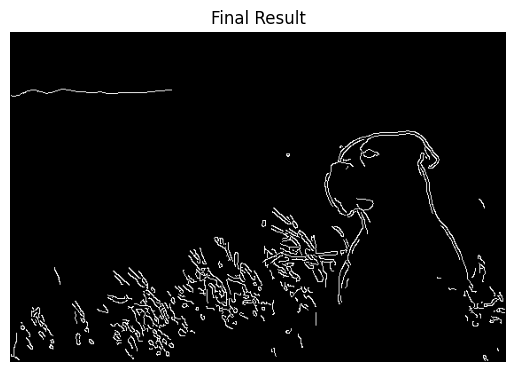

'\nOutput Gambar :\nPixel yang memiliki weak edge namun edge asli sudah menjadi strong edge.\nPixel yang memiliki weak edge dan bukan edge sudah dihilangkan.\n\nTersisa hanya strong edge.\n'

In [9]:
def hysteresis(img) :
    
    '''
    Fungsi untuk melakukan tracking pada edge yang lemah. Jika neighbour di sekitar edge yangf lemah tidak ada yang strong, maka harus dibuang. Sebaliknya edge yang lemah tersebut harus dibuat menjadi strong.
    '''
    
    # Menentukan height dan width gambar menggunakan img.shape
    height, width = img.shape
    
    # Define intensitas yang lemah dan yang kuat. Lemah = 150 dan Kuat = 255
    strong = np.int32(255)
    weak = np.int32(150)
    
    for i in range(1, height - 1) :
        for j in range(1, width - 1) :
            if img[i, j] == weak : # Jika edge weak 
                # Perika apakah di sekitar pixel ini ada pixel yang strong
                if ((img[i + 1, j - 1] == strong) or (img[i + 1, j] == strong) or (img[i + 1, j + 1] == strong) or (img[i, j - 1] == strong) or (img[i, j + 1] == strong) or (img[i - 1, j - 1] == strong) or (img[i - 1, j] == strong) or (img[i - 1, j + 1] == strong)): 
                    img[i, j] = strong # Jika iya -> Ubah jadi strng
                else : 
                    img[i, j] = 0 # Jika tidak -> Hapus
                    
    return img


result = hysteresis(thresh_img)
show_image('Final Result', result)

'''
Output Gambar :
Pixel yang memiliki weak edge namun edge asli sudah menjadi strong edge.
Pixel yang memiliki weak edge dan bukan edge sudah dihilangkan.

Tersisa hanya strong edge.
'''